# Data Ingestion

## Copy CSV files to S3

In [2]:
# Assume all the pre-requisites were set up 
%store -r setup_instance_check_passed
%store -r setup_dependencies_passed
%store -r setup_s3_bucket_passed
%store -r setup_iam_roles_passed


In [3]:
# Load Libraries
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [4]:
# Public Data
!aws s3 ls s3://ads508team5/

# Copy Datasets from :
# Source of data
s3_public_path_tweeter = "s3://ads508team5/tweeter"
s3_public_path_nyt = "s3://ads508team5/nyt"
s3_public_path_cities = "s3://ads508team5/cities"

# Destination Data:
s3_private_path_tweeter = "s3://{}/ADS508_project/tweeter".format(bucket)
s3_private_path_nyt = "s3://{}/ADS508_project/nyt".format(bucket)
s3_private_path_cities = "s3://{}/ADS508_project/cities".format(bucket)

# Copy datasets
!aws s3 cp --recursive $s3_public_path_tweeter/ $s3_private_path_tweeter/ --exclude "*" --include "hashtag_donaldtrump.csv"
!aws s3 cp --recursive $s3_public_path_tweeter/ $s3_private_path_tweeter/ --exclude "*" --include "hashtag_joebiden.csv"
!aws s3 cp --recursive $s3_public_path_nyt/ $s3_private_path_nyt/ --exclude "*" --include "nyt-comments-2020.csv"
!aws s3 cp --recursive $s3_public_path_cities/ $s3_private_path_cities/ --exclude "*" --include "uscities.csv"

                           PRE cities/
                           PRE nyt/
                           PRE tweeter/
copy: s3://ads508team5/tweeter/hashtag_donaldtrump.csv to s3://sagemaker-us-east-1-975050119017/ADS508_project/tweeter/hashtag_donaldtrump.csv
copy: s3://ads508team5/tweeter/hashtag_joebiden.csv to s3://sagemaker-us-east-1-975050119017/ADS508_project/tweeter/hashtag_joebiden.csv
copy: s3://ads508team5/nyt/nyt-comments-2020.csv to s3://sagemaker-us-east-1-975050119017/ADS508_project/nyt/nyt-comments-2020.csv
copy: s3://ads508team5/cities/uscities.csv to s3://sagemaker-us-east-1-975050119017/ADS508_project/cities/uscities.csv


## Create Database, Tables and Parquets
### Database

In [5]:
# Setup and check pre-requisites to create Database
ingest_create_athena_db_passed = False

!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [6]:

# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

# Create Connection
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [7]:
# Create Database
database_name = "dbpoliticpulsecomment"

statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)

pd.read_sql(statement, conn)

# Verify DB successfully created
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)


,database_name
0,dbpoliticpulsecomment
1,default


In [8]:
# End of Create Database
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

### Tables

In [9]:
# Create Tweeter Tables
table_name_csv = "tweeter"
s3_private_path_tweeter = "s3://{}/ADS508_project/tweeter".format(bucket)

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
  created_at TIMESTAMP,
  tweet_id FLOAT,
  tweet VARCHAR(250),
  likes INT,
  retweet_count INT,
  source VARCHAR(45),
  user_id INT,
  user_name VARCHAR(250),
  user_screen_name VARCHAR(45),
  user_description VARCHAR(250),
  user_join_date TIMESTAMP,
  user_followers_count INT,
  user_location VARCHAR(45),
  lat FLOAT,
  long FLOAT,
  city VARCHAR(45),
  country VARCHAR(45),
  continent VARCHAR(45),
  state VARCHAR(45),
  state_code VARCHAR(45),
  collected_at VARCHAR(45)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_tweeter
)

pd.read_sql(statement, conn)


""


In [10]:
# testing hashtag_donaldtrump.csv tweet
tweet = "You get a tie! And you get a tie! #Trump ‘s rally #Iowa https://t.co/jJalUUmh5D"
# testing hashtag_joebiden.csv tweet
tweet = "@chrislongview Watching and setting dvr. Let’s give him bonus ratings!! #JoeBiden"


statement = """SELECT * FROM {}.{}
    WHERE tweet = '{}' LIMIT 100""".format(
    database_name, table_name_csv, tweet
)

df = pd.read_sql(statement, conn)
df.head(5)


,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,None,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0,0,Twitter for iPhone,None,Michelle Ferg,MichelleFerg4,,...,27,,None,None,,,,,,00:01.6


In [11]:
# Create NYT comment Table
table_name_csv = "nyt_comment"
s3_private_path_nyt = "s3://{}/ADS508_project/nyt".format(bucket)


statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
  commentID INT,
  status VARCHAR(20),
  commentSequence INT,
  userID INT,
  userDisplayName VARCHAR(45),
  userLocation VARCHAR(45),
  userTitle VARCHAR(10),
  commentBody VARCHAR(500),
  createDate TIMESTAMP,
  updateDate TIMESTAMP,
  approveDate TIMESTAMP,
  recommendation INT,
  replyCount INT,
  editorsSelection VARCHAR(20),
  parentID INT,
  parentUserDisplayName VARCHAR(45),
  depth INT,
  commentType VARCHAR(20),
  trusted VARCHAR(20),
  recommendedFlag VARCHAR(20),
  permID INT,
  isAnonymous VARCHAR(20),
  articleID VARCHAR(150)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_nyt
)

pd.read_sql(statement, conn)


""


In [12]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,tab_name
0,cleandata
1,comment
2,comment_parquet
3,nyt_comment
4,tweeter


In [13]:
commentBody = "@Philip Brown Agree 110%."

statement = """SELECT * FROM {}.{}
    WHERE commentBody = '{}' LIMIT 100""".format(
    database_name, table_name_csv, commentBody
)

df = pd.read_sql(statement, conn)
df.head(5)


,commentid,status,commentsequence,userid,userdisplayname,userlocation,usertitle,commentbody,createdate,updatedate,...,editorsselection,parentid,parentuserdisplayname,depth,commenttype,trusted,recommendedflag,permid,isanonymous,articleid
0,104389709,approved,104389709,72038931,Anthony Monaghan,Narrabeen,,@Philip Brown Agree 110%.,2020-01-01 10:36:20,2020-01-01 21:18:55,...,False,104389536,Philip Brown,2,userReply,0,0,104389709,False,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...


In [14]:
# Create uscities table
table_name = "uscities"
s3_private_path_cities = "s3://{}/ADS508_project/cities".format(bucket)

statement = """
CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
    city VARCHAR(45),
    state_id VARCHAR(2),
    state_name VARCHAR(30)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')
""".format(
    database_name, table_name, s3_private_path_cities
)

pd.read_sql(statement, conn)


""


### Parquets
#### Feature Selection and Creation
Prior creating a parquet table, tweeter and NYT comment tables are going to be combined under Comment Table in Athena where a feature creation is going to be performed. When the table is combined, we selected some features that would be benefit to our goal.

Selected features which could help on train the model are comment_body, user_location, candidatepoll

In [15]:
table_comment = "comment"
table_tweeter = "tweeter"
table_nyt_comment = "nyt_comment"

# SQL Statement combine tweeter and NYT comment in the preparation to create parquet
statement = """
CREATE TABLE IF NOT EXISTS {}.{} AS (
SELECT DISTINCT
    tweet_id AS comment_id,
    tweet AS comment_body,
    user_id AS user_id,
    user_name AS user_name,
    user_location AS user_location,
    u.state_id AS user_state,
    created_at AS create_date,
    retweet_count AS reply_retweet,
    likes AS recommendation_like,
    'tweet' as source,
    (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') AS trump_count,
    (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') AS biden_count,
    CASE 
        WHEN 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') > 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') 
        THEN 'Biden'
        WHEN              
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') < 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') 
        THEN 'Trump'
        ELSE NULL
    END AS candidatepoll
FROM
    {}.{}
LEFT JOIN
    dbpoliticpulsecomment.uscities u ON lower(user_location) = lower(u.city) OR 
    lower(user_location) = lower(u.state_name) OR 
    lower(user_location) = lower(u.state_id)
WHERE
    LENGTH(tweet) > 3
UNION
SELECT DISTINCT
    commentid AS comment_id,
    commentbody AS comment_body,
    userID AS user_id,
    userDisplayName AS user_name,
    userLocation AS user_location,
    u.state_id as user_state,
    createDate AS create_date,
    replyCount AS reply_retweet,
    recommendation AS recommendation_like,
    'nyt_comment' as source,
    (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') AS trump_count,
    (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') AS biden_count,
    CASE
        WHEN
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') > 
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') 
        THEN 'Biden'
        WHEN
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') < 
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') 
        THEN 'Trump'
        ELSE NULL
    END AS candidatepoll
FROM 
    {}.{}
LEFT JOIN
    dbpoliticpulsecomment.uscities u ON lower(userLocation) = lower(u.city) OR 
    lower(userLocation) = lower(u.state_name) OR 
    lower(userLocation) = lower(u.state_id)
WHERE LENGTH(commentbody) > 3
)""".format(database_name, table_comment,database_name, table_tweeter,database_name, table_nyt_comment)

pd.read_sql(statement, conn)

,rows


In [16]:
commentbody = "Joe Biden"
source = "nyt_comment"

statement = """SELECT * FROM {}.{}
    WHERE comment_body like '{}%' and source = '{}' LIMIT 100""".format(
    database_name, table_comment, commentbody, source
)

df = pd.read_sql(statement, conn)
df.head(5)


,comment_id,comment_body,user_id,user_name,user_location,create_date,reply_retweet,recommendation_like,source,trump_count,biden_count,candidatepoll
0,105742976.0,Joe Biden spent his career trying to cut socia...,60956830,Bilal Khan,Phnom Penh,2020-03-11 11:50:58,0,54,nyt_comment,0,1,Biden
1,110479360.0,Joe Biden has a very important factor in his f...,78343265,KMW,New York City,2020-12-06 17:44:25,3,4,nyt_comment,1,3,Biden
2,110479616.0,Joe Biden doesn’t speak with confidence and he...,78343265,KMW,New York City,2020-12-06 18:01:34,1,5,nyt_comment,0,1,Biden
3,107597560.0,Joe Biden needs to commit to Medicare For All....,38455006,dmbones,Portland Oregon,2020-06-14 17:48:46,2,4,nyt_comment,0,1,Biden
4,110042400.0,Joe Biden has been around for a long time and ...,56062707,Timothy,Toronto,2020-11-09 18:48:39,0,9,nyt_comment,0,1,Biden


In [17]:
# Setup to create Parquet
ingest_create_athena_table_parquet_passed = False

# Set S3 path to Parquet data
s3_path_parquet = "s3://{}/ADS508_project/parquet".format(bucket)

table_parquet = "comment_parquet"

In [18]:
# SQL statement to execute (remove comment_id, user_name,)
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}', partitioned_by = ARRAY['candidatepoll']) AS
SELECT DISTINCT user_location,
         user_state,
         comment_body,
         source,
         candidatepoll
FROM {}.{}
where candidatepoll is not null AND Length(comment_body)>1 AND length(user_location)>1""".format(
    database_name, table_parquet, s3_path_parquet, database_name, table_comment
)
pd.read_sql(statement, conn)

,rows


In [19]:
#load the Parquet partitions
statement = "MSCK REPAIR TABLE {}.{}".format(database_name, table_parquet)

df = pd.read_sql(statement, conn)
df.head(5)

""


In [20]:
statement = "SHOW PARTITIONS {}.{}".format(database_name, table_parquet)
df_partitions = pd.read_sql(statement, conn)
df_partitions.head(5)

,partition
0,candidatepoll=Biden
1,candidatepoll=__HIVE_DEFAULT_PARTITION__
2,candidatepoll=Trump


In [21]:
statement = "SHOW TABLES in {}".format(database_name)
df_partitions = pd.read_sql(statement, conn)
df_partitions.head(5)

,tab_name
0,cleandata
1,comment
2,comment_parquet
3,nyt_comment
4,tweeter


In [22]:
candidatepoll = "Trump"

statement = """SELECT * FROM {}.{}
    Where candidatepoll = '{}' LIMIT 10""".format(
    database_name, table_parquet, candidatepoll
)
df_parquet = pd.read_sql(statement, conn)
df_parquet.head(5)

,comment_id,user_name,user_location,comment_body,reply_retweet,recommendation_like,source,trump_count,biden_count,candidatepoll
0,1.325145e+18,None,None,"""Se #Trump e gli americani si arrendono di fro...",NaN,NaN,tweet,1,0,Trump
1,1.325145e+18,None,None,"""In a few years when Trump’s debts come due:",NaN,NaN,tweet,1,0,Trump
2,1.325145e+18,None,None,"""Quote from my 8 year old: #Biden and #Trump a...",NaN,NaN,tweet,2,1,Trump
3,1.325145e+18,K-Dub,Florida transplant..WV native,@realDonaldTrump @DonaldJTrumpJr @EricTrump @I...,0.0,0.0,tweet,4,2,Trump
4,1.325145e+18,Ethan P,"""Detroit",@realDonaldTrump this you? #Biden #Trump #Elec...,0.0,0.0,tweet,2,1,Trump


## Query Data

In [23]:
# Setup and check pre-requisites to create Database

!pip install --disable-pip-version-check -q awswrangler
import awswrangler as wr

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [24]:
t_filter = lambda x: x["candidatepoll"] == "Trump"
b_filter = lambda x: x["candidatepoll"] == "Biden"

In [25]:
path =  "s3://{}/ADS508_project/parquet".format(bucket)

df_parquet_results = wr.s3.read_parquet(
    path, columns=["comment_body", "source", "user_location", "candidatepoll"], partition_filter=t_filter, dataset=True
)

#"user_state", 


In [26]:
df_parquet_results_trump = df_parquet_results.drop_duplicates(subset = ['comment_body'])
df_parquet_results_trump.shape
df_parquet_results_trump.head(5)

,comment_body,source,user_location,candidatepoll
0,"""Ma la signora Maglie che nelle sue dirette ci...",tweet,<NA>,Trump
1,#ByeByeTrump #Election2020results #Election202...,tweet,HE%SHE ☆ﾐ,Trump
2,"""Finally a real president! Trump supporters",tweet,<NA>,Trump
3,"""#ByeByeTrump you are gefeuert..",tweet,<NA>,Trump
4,"""Trump be like : accha main chlta hu duao main...",tweet,<NA>,Trump


In [27]:
path =  "s3://{}/ADS508_project/parquet".format(bucket)

# Call all public discourse data from 
df_parquet_results = wr.s3.read_parquet(
    path, columns=["comment_body", "source", "user_location", "candidatepoll"], partition_filter=b_filter, dataset=True
)

# "user_state",
df_parquet_results_biden = df_parquet_results.drop_duplicates(subset = ['comment_body'])
df_parquet_results_biden.shape
df_parquet_results_biden.head(5)

,comment_body,source,user_location,candidatepoll
0,We can all breathe now . #Biden,tweet,NY 🍎 LA | 🌎 Traveler | Not All Those Who Wan,Biden
1,#KamalaHarrisVP #JoeBiden JOE AND KAMALA DO ...,tweet,,Biden
2,Thank you @KingJames @CP3 &amp; the sporting w...,tweet,,Biden
3,"""@BBCNews #JoeBiden can we please savour this ...",tweet,158.0,Biden
4,#Merkel #Allemagne #Biden https://t.co/fyq8r3siwN,tweet,"""Montréal",Biden


# Data Exploration before Any Feature Transformation

In [28]:
# Checking for missing values from trump data
df_parquet_results_trump.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 926684 entries, 0 to 1005921
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   comment_body   926684 non-null  string  
 1   source         926684 non-null  string  
 2   user_location  734730 non-null  string  
 3   candidatepoll  926684 non-null  category
dtypes: category(1), string(3)
memory usage: 29.2 MB


In [29]:
# Check for missing values from  biden data
df_parquet_results_biden.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 434926 entries, 0 to 489257
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   comment_body   434926 non-null  string  
 1   source         434926 non-null  string  
 2   user_location  309544 non-null  string  
 3   candidatepoll  434926 non-null  category
dtypes: category(1), string(3)
memory usage: 13.7 MB


In [30]:
# Data Distributions for Trump and Biden 
df_parquet_results_trump['source'].value_counts()


tweet          534164
nyt_comment    392520
Name: source, dtype: Int64

In [31]:
# Data Distributions for Trump and Biden 
df_parquet_results_biden['source'].value_counts()

tweet          373111
nyt_comment     61815
Name: source, dtype: Int64

In [32]:
# Filtering Data by Location 
df_parquet_results_trump['user_location'].value_counts()

                       64386
NYC                    13500
California             11833
New York               11430
USA                     8574
                       ...  
2012-03-12 17:37:04        1
"Domlur                    1
NeverLand                  1
 Linguistics               1
 in capacities             1
Name: user_location, Length: 94261, dtype: Int64

In [33]:
# Top 30 locations of social media activity
df_parquet_results_trump['user_location'].value_counts().head(30)

                 64386
NYC              13500
California       11833
New York         11430
USA               8574
Chicago           6946
Los Angeles       6683
NY                6620
San Francisco     6226
Seattle           6034
Florida           5697
NJ                5514
Boston            5312
United States     4948
New York City     4226
Canada            4207
New Jersey        3987
Colorado          3779
Brooklyn          3735
Texas             3720
CA                3481
Philadelphia      3156
Massachusetts     2766
Oregon            2758
Virginia          2721
Atlanta           2686
San Diego         2529
NC                2396
Maryland          2393
Midwest           2301
Name: user_location, dtype: Int64

In [34]:
df_parquet_results_biden['user_location'].value_counts()

                           49144
United States               3484
New York                    2486
NYC                         2397
USA                         2283
                           ...  
Cypress TX                     1
 Managing Editor               1
326803.0                       1
Nottingham/St.Lucia            1
Hopefully On A Sailboat        1
Name: user_location, Length: 73587, dtype: Int64

In [35]:
# Top 30 locations of social media activity
df_parquet_results_biden['user_location'].value_counts().head(30)

                 49144
United States     3484
New York          2486
NYC               2397
USA               2283
California        1806
NY                1290
"Los Angeles      1227
"New York         1223
Chicago           1142
Los Angeles       1089
San Francisco     1086
Seattle            984
Florida            984
"California        971
Boston             850
"Washington        794
NJ                 791
Texas              759
Virginia           757
Canada             718
"Florida           715
New York City      710
New Jersey         671
Brooklyn           630
"London            611
CA                 575
Colorado           560
Earth              557
"Texas             554
Name: user_location, dtype: Int64

# Create EDA Overview Data Visualization

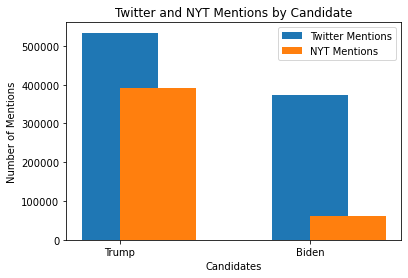

In [36]:
# Data Sources for Each Candidate
# Code from ChatGPT

import matplotlib.pyplot as plt

candidate = ['Trump','Biden']
twitter_n = [df_parquet_results_trump['source'].value_counts()[0],df_parquet_results_biden['source'].value_counts()[0]]
nyt_n = [df_parquet_results_trump['source'].value_counts()[1],df_parquet_results_biden['source'].value_counts()[1]]

x = range(len(candidate))

# Plotting the bars
plt.bar(x, twitter_n, width=0.4, label='Twitter Mentions', align='center')
plt.bar(x, nyt_n, width=0.4, label='NYT Mentions', align='edge')

# Adding labels
plt.xlabel('Candidates')
plt.ylabel('Number of Mentions')
plt.title('Twitter and NYT Mentions by Candidate')
plt.xticks(x, candidate)
plt.legend()

# Show plot
plt.savefig('DataDist.png')

## Standardizing Text Entries and Location Data

In [37]:
!pip install emoji

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [38]:
import re
import emoji

# Function to preprocess text data
def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    # Replace emojis with text labels
    text = emoji.demojize(text)
    # Remove URLs
    text = re.sub(r'http\S+', ' ', text)
    # Remove "#" from hashtags
    text = re.sub(r'#', '', text)
    # Remove "@" from mentions
    text = re.sub(r'@', '', text)
    # Remove extra spaces while preserving at least one space between words
    text = re.sub(r'\s+', ' ', text)
    # Check if the text consists only of numbers
    if text.isdigit():
        text = "NA"
    return text



In [39]:
df_parquet_results_biden['user_location'] = df_parquet_results_biden['user_location'].astype(str)
df_parquet_results_trump['user_location'] = df_parquet_results_trump['user_location'].astype(str)

/tmp/ipykernel_4189/682625606.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parquet_results_biden['user_location'] = df_parquet_results_biden['user_location'].astype(str)


In [40]:
# Apply preprocessing to text columns in the dataframe
df_parquet_results_biden['clean_text'] = df_parquet_results_biden['comment_body'].apply(preprocess_text)

/tmp/ipykernel_4189/3431105715.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parquet_results_biden['clean_text'] = df_parquet_results_biden['comment_body'].apply(preprocess_text)


In [41]:
df_parquet_results_biden['clean_location'] = df_parquet_results_biden['user_location'].apply(preprocess_text)

/tmp/ipykernel_4189/400958404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parquet_results_biden['clean_location'] = df_parquet_results_biden['user_location'].apply(preprocess_text)


In [42]:
df_parquet_results_trump['clean_text'] = df_parquet_results_trump['comment_body'].apply(preprocess_text)

In [43]:
df_parquet_results_trump['clean_location'] = df_parquet_results_trump['user_location'].apply(preprocess_text)

In [44]:
df_parquet_results_trump.head()

,comment_body,source,user_location,candidatepoll,clean_text,clean_location
0,"""Ma la signora Maglie che nelle sue dirette ci...",tweet,<NA>,Trump,Ma la signora Maglie che nelle sue dirette ci...,NA
1,#ByeByeTrump #Election2020results #Election202...,tweet,HE%SHE ☆ﾐ,Trump,ByeByeTrump Election2020results Election2020 ...,HE SHE ﾐ
2,"""Finally a real president! Trump supporters",tweet,<NA>,Trump,Finally a real president Trump supporters,NA
3,"""#ByeByeTrump you are gefeuert..",tweet,<NA>,Trump,ByeByeTrump you are gefeuert,NA
4,"""Trump be like : accha main chlta hu duao main...",tweet,<NA>,Trump,Trump be like accha main chlta hu duao main y...,NA


In [45]:
df_parquet_results_biden.head()

,comment_body,source,user_location,candidatepoll,clean_text,clean_location
0,We can all breathe now . #Biden,tweet,NY 🍎 LA | 🌎 Traveler | Not All Those Who Wan,Biden,We can all breathe now Biden,NY LA Traveler Not All Those Who Wan
1,#KamalaHarrisVP #JoeBiden JOE AND KAMALA DO ...,tweet,,Biden,KamalaHarrisVP JoeBiden JOE AND KAMALA DO NOT...,
2,Thank you @KingJames @CP3 &amp; the sporting w...,tweet,,Biden,Thank you KingJames CP3 amp the sporting world...,
3,"""@BBCNews #JoeBiden can we please savour this ...",tweet,158.0,Biden,BBCNews JoeBiden can we please savour this mo...,158 0
4,#Merkel #Allemagne #Biden https://t.co/fyq8r3siwN,tweet,"""Montréal",Biden,Merkel Allemagne Biden t co fyq8r3siwN,Montréal


# Word Clouds with Comment Body Text

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


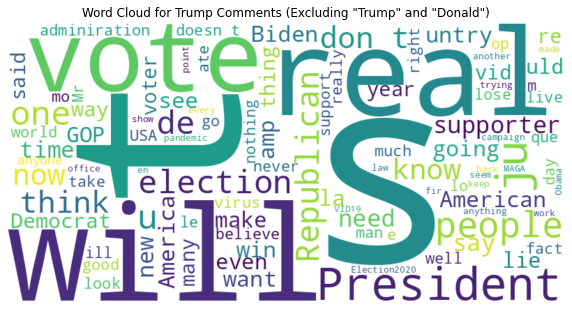

In [46]:
!pip install WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Sample a subset of comments for generating the word cloud
sampled_trump_comments = df_parquet_results_trump['clean_text'].dropna().sample(n=10000, random_state=42)

# Concatenate sampled comments for Trump
trump_comments_text = ' '.join(sampled_trump_comments)

# Define words and patterns to exclude
words_to_exclude = ['trump', 'donald', 'donaldtrump', 'https', 'co', 'st'] 
patterns_to_exclude = [r'\btrump\b', r'\bdonald\b', r'\bdonaldtrump\b', r'https?://\S+']

# Combine words and patterns to exclude
exclude_patterns = '|'.join(words_to_exclude + patterns_to_exclude)

# Preprocess text to remove specific words and patterns
trump_comments_text_cleaned = re.sub(exclude_patterns, '', trump_comments_text, flags=re.IGNORECASE)

# Generate word cloud for Trump comments with a limit on the number of words
wordcloud_trump = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(trump_comments_text_cleaned)

# Plot the word cloud for Trump
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_trump, interpolation='bilinear')
plt.title('Word Cloud for Trump Comments (Excluding "Trump" and "Donald")')
plt.axis('off')
plt.show()

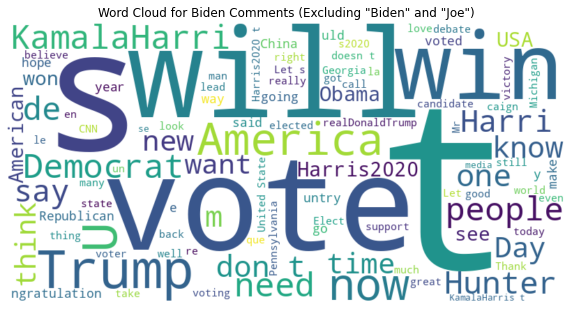

In [47]:
# Sample a subset of comments for Biden
sampled_biden_comments = df_parquet_results_biden['clean_text'].dropna().sample(n=40000, random_state=42)

# Concatenate sampled comments for Biden
biden_comments_text = ' '.join(sampled_biden_comments)

# Define words and patterns to exclude
words_to_exclude = ['biden', 'joe', 'joebiden', 'president', 'election', 'https', 'co','amp']  # Exclude common words and URLs
patterns_to_exclude = [r'\bbiden\b', r'\bjoe\b', r'\bjoebiden\b', r'https?://\S+']

# Combine words and patterns to exclude
exclude_patterns = '|'.join(words_to_exclude + patterns_to_exclude)

# Preprocess text to remove specific words and patterns
biden_comments_text_cleaned = re.sub(exclude_patterns, '', biden_comments_text, flags=re.IGNORECASE)

# Generate word cloud for Biden comments with a limit on the number of words
wordcloud_biden = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(biden_comments_text_cleaned)

# Plot the word cloud for Biden
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_biden, interpolation='bilinear')
plt.title('Word Cloud for Biden Comments (Excluding "Biden" and "Joe")')
plt.axis('off')
plt.show()

# Feature Transformation and Data Cleaning

### Sentiment Labels Using Textblob and Stripping Out Non-English Text Entries with Fasttext.

### This code must be ran on Mac/Linux only. Windows is not compatible. Clean data from this code is stored in an S3 bucket and called below.

In [48]:
#pip install langdetect

In [49]:
#pip install fasttext-wheel

In [50]:
#Use pretrained model
#!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin -P /ADS508_GroupProject
#!ls -p /ADS508_GroupProject

In [51]:
#import fasttext
# Load the pre-trained language identification model
#model_path = '/ADS508_GroupProject/lid.176.bin'  # Path to the pre-trained language identification model
#model = fasttext.load_model(model_path)

In [52]:
# Function to detect language using FastText
#def detect_language_fasttext(text):
#    prediction = model.predict(text)
#    language_code = prediction[0][0].split('__label__')[1]
#    return language_code

# Function to analyze tweet sentiment to catch non english words
#def analyze_tweet_sentiment(tweet_text):
#    try:
#        language = detect_language_fasttext(tweet_text)
#        if language == 'en':
#            analysis = TextBlob(tweet_text)
#            return analysis.sentiment.polarity
#        else:
#            return None
#    except:
#        return None



In [53]:
!pip install textblob
from textblob import TextBlob
def analyze_tweet_sentiment(tweet_text):
    analysis = TextBlob(tweet_text)
    # Return sentiment polarity (ranging from -1 to 1)
    return analysis.sentiment.polarity

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [54]:
# Apply sentiment labels to Trump Data
if __name__ == "__main__":
    # Assuming you have a DataFrame named df_tweets with a column 'text' containing tweet text
    df_tweets_trump = df_parquet_results_trump[['clean_text']]
    # Analyze sentiment for each tweet in the DataFrame
    df_tweets_trump['sentiment_score'] = df_tweets_trump['clean_text'].apply(analyze_tweet_sentiment)

# Add sentiment output to parent dataframe
df_parquet_results_trump['sentiment'] = df_tweets_trump['sentiment_score']

/tmp/ipykernel_4189/4017857091.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_trump['sentiment_score'] = df_tweets_trump['clean_text'].apply(analyze_tweet_sentiment)


In [55]:
 # Apply Sentiment labels to Biden Data       
if __name__ == "__main__":
    # Assuming you have a DataFrame named df_tweets with a column 'text' containing tweet text
    df_tweets_biden = df_parquet_results_biden[['clean_text']]
    # Analyze sentiment for each tweet in the DataFrame
    df_tweets_biden['sentiment_score'] = df_tweets_biden['clean_text'].apply(analyze_tweet_sentiment)

# Add sentiment output to parent dataframe
df_parquet_results_biden['sentiment'] = df_tweets_biden['sentiment_score']


/tmp/ipykernel_4189/2765627512.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_biden['sentiment_score'] = df_tweets_biden['clean_text'].apply(analyze_tweet_sentiment)
/tmp/ipykernel_4189/2765627512.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parquet_results_biden['sentiment'] = df_tweets_biden['sentiment_score']


In [56]:
df_parquet_results_trump.head(5)

,comment_body,source,user_location,candidatepoll,clean_text,clean_location,sentiment
0,"""Ma la signora Maglie che nelle sue dirette ci...",tweet,<NA>,Trump,Ma la signora Maglie che nelle sue dirette ci...,NA,0.000000
1,#ByeByeTrump #Election2020results #Election202...,tweet,HE%SHE ☆ﾐ,Trump,ByeByeTrump Election2020results Election2020 ...,HE SHE ﾐ,0.000000
2,"""Finally a real president! Trump supporters",tweet,<NA>,Trump,Finally a real president Trump supporters,NA,0.200000
3,"""#ByeByeTrump you are gefeuert..",tweet,<NA>,Trump,ByeByeTrump you are gefeuert,NA,0.000000
4,"""Trump be like : accha main chlta hu duao main...",tweet,<NA>,Trump,Trump be like accha main chlta hu duao main y...,NA,0.166667


In [57]:
df_parquet_results_biden.head(5)

,comment_body,source,user_location,candidatepoll,clean_text,clean_location,sentiment
0,We can all breathe now . #Biden,tweet,NY 🍎 LA | 🌎 Traveler | Not All Those Who Wan,Biden,We can all breathe now Biden,NY LA Traveler Not All Those Who Wan,0.00
1,#KamalaHarrisVP #JoeBiden JOE AND KAMALA DO ...,tweet,,Biden,KamalaHarrisVP JoeBiden JOE AND KAMALA DO NOT...,,0.33
2,Thank you @KingJames @CP3 &amp; the sporting w...,tweet,,Biden,Thank you KingJames CP3 amp the sporting world...,,0.00
3,"""@BBCNews #JoeBiden can we please savour this ...",tweet,158.0,Biden,BBCNews JoeBiden can we please savour this mo...,158 0,0.00
4,#Merkel #Allemagne #Biden https://t.co/fyq8r3siwN,tweet,"""Montréal",Biden,Merkel Allemagne Biden t co fyq8r3siwN,Montréal,0.00


## Combine candidate data

In [58]:
df_combined = pd.concat([df_parquet_results_biden, df_parquet_results_trump], ignore_index=True)

### Create sentiment labels

In [59]:
df_combined['sentiment_category'] = df_combined['sentiment'].apply(lambda x: 'negative' if x < 0 else ('positive' if x > 0 else 'neutral'))

In [60]:

df_combined.head()


,comment_body,source,user_location,candidatepoll,clean_text,clean_location,sentiment,sentiment_category
0,We can all breathe now . #Biden,tweet,NY 🍎 LA | 🌎 Traveler | Not All Those Who Wan,Biden,We can all breathe now Biden,NY LA Traveler Not All Those Who Wan,0.00,neutral
1,#KamalaHarrisVP #JoeBiden JOE AND KAMALA DO ...,tweet,,Biden,KamalaHarrisVP JoeBiden JOE AND KAMALA DO NOT...,,0.33,positive
2,Thank you @KingJames @CP3 &amp; the sporting w...,tweet,,Biden,Thank you KingJames CP3 amp the sporting world...,,0.00,neutral
3,"""@BBCNews #JoeBiden can we please savour this ...",tweet,158.0,Biden,BBCNews JoeBiden can we please savour this mo...,158 0,0.00,neutral
4,#Merkel #Allemagne #Biden https://t.co/fyq8r3siwN,tweet,"""Montréal",Biden,Merkel Allemagne Biden t co fyq8r3siwN,Montréal,0.00,neutral


In [61]:
df_combined.shape

(1361610, 8)

# Additional EDA with Clean Language Data

## Trump Data

In [62]:
# Examine Trump Sentiment distribution
df_combined[df_combined['candidatepoll'] == 'Trump']['sentiment'].value_counts()

 0.000000    448369
 0.500000     28099
 0.200000     18034
 0.250000     15523
 0.100000     12534
              ...  
 0.046389         1
-0.295238         1
 0.210714         1
-0.592857         1
-0.008036         1
Name: sentiment, Length: 26016, dtype: int64

In [233]:
df_combined[(df_combined['candidatepoll'] == 'Trump') & (df_combined['sentiment'] < 0)].head(5)

,comment_body,source,user_location,candidatepoll,clean_text,clean_location,sentiment,sentiment_category,SentimentOutcome
434932,Total LOSER @POTUS @realDonaldTrump @FLOTUS @E...,tweet,France,Trump,Total LOSER POTUS realDonaldTrump FLOTUS EricT...,France,-0.200000,negative,Trump_negative
434934,"""@realDonaldTrump is a disgrace. Trump is not ...",tweet,<NA>,Trump,realDonaldTrump is a disgrace Trump is not on...,NA,-0.250000,negative,Trump_negative
434936,"""I hope they refuse to move into the White Hou...",tweet,<NA>,Trump,I hope they refuse to move into the White Hou...,NA,-0.016667,negative,Trump_negative
434937,"""#Trump has not gained as much as one big elec...",tweet,97.0,Trump,Trump has not gained as much as one big elect...,97 0,-0.033333,negative,Trump_negative
434939,"""@matteosalvinimi @realDonaldTrump ... Black F...",tweet,<NA>,Trump,matteosalvinimi realDonaldTrump Black Friday ...,NA,-0.166667,negative,Trump_negative


In [64]:
df_combined[(df_combined['candidatepoll'] == 'Trump') & (df_combined['sentiment'] == 0)].head(5)

,comment_body,source,user_location,candidatepoll,clean_text,clean_location,sentiment,sentiment_category
434926,"""Ma la signora Maglie che nelle sue dirette ci...",tweet,<NA>,Trump,Ma la signora Maglie che nelle sue dirette ci...,NA,0.0,neutral
434927,#ByeByeTrump #Election2020results #Election202...,tweet,HE%SHE ☆ﾐ,Trump,ByeByeTrump Election2020results Election2020 ...,HE SHE ﾐ,0.0,neutral
434929,"""#ByeByeTrump you are gefeuert..",tweet,<NA>,Trump,ByeByeTrump you are gefeuert,NA,0.0,neutral
434931,"""Igualmente es de destacar como Trump conservó...",tweet,<NA>,Trump,Igualmente es de destacar como Trump conservó...,NA,0.0,neutral
434933,"""Trump: """"Uncle! Uncle!""""",tweet,<NA>,Trump,Trump Uncle Uncle,NA,0.0,neutral


In [65]:
df_combined[(df_combined['candidatepoll'] == 'Trump') & (df_combined['sentiment'] > 0)].head(5)

,comment_body,source,user_location,candidatepoll,clean_text,clean_location,sentiment,sentiment_category
434928,"""Finally a real president! Trump supporters",tweet,<NA>,Trump,Finally a real president Trump supporters,NA,0.200000,positive
434930,"""Trump be like : accha main chlta hu duao main...",tweet,<NA>,Trump,Trump be like accha main chlta hu duao main y...,NA,0.166667,positive
434952,Hope we Europeans wake up to good news tomorro...,tweet,Norway,Trump,Hope we Europeans wake up to good news tomorro...,Norway,0.700000,positive
434965,"""@guardian Sad to see. The only way @realDonal...",tweet,<NA>,Trump,guardian Sad to see The only way realDonaldTr...,NA,0.200000,positive
434974,"""#Trump was big on symbols and liked to appear...",tweet,<NA>,Trump,Trump was big on symbols and liked to appear ...,NA,0.070370,positive


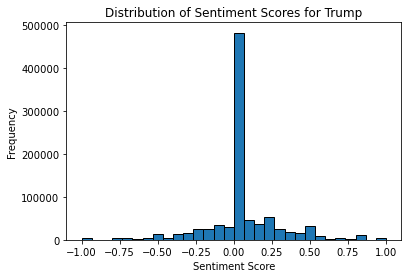

In [66]:
plt.hist(df_combined[df_combined['candidatepoll'] == 'Trump']['sentiment'], bins=30, edgecolor='black')

# Adding labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores for Trump')

# Show plot
plt.savefig('TrumpSentDist.png')

### Biden Data

In [67]:
df_combined[df_combined['candidatepoll'] == 'Biden']['sentiment'].value_counts()

 0.000000    256228
 0.500000     13183
 0.800000     11414
 0.200000      6573
 0.300000      6435
              ...  
 0.414394         1
 0.145202         1
 0.115873         1
 0.004861         1
-0.099107         1
Name: sentiment, Length: 10409, dtype: int64

In [68]:
df_combined[(df_combined['candidatepoll'] == 'Biden') & (df_combined['sentiment'] < 0)].head(5)

,comment_body,source,user_location,candidatepoll,clean_text,clean_location,sentiment,sentiment_category
19,"""The only people stupid enough to believe #Joe...",tweet,<NA>,Biden,The only people stupid enough to believe JoeB...,NA,-0.175,negative
44,The evil has been vanquished. #JoeBiden #JOEBI...,tweet,2009-07-11 02:11:26,Biden,The evil has been vanquished JoeBiden JOEBIDEN...,2009 07 11 02 11 26,-1.000,negative
59,J’espère qu’on ne regrettera pas l’arrivée de ...,tweet,"""Strasbourg",Biden,J espère qu on ne regrettera pas l arrivée de ...,Strasbourg,-0.100,negative
89,Trumps just making baseless claims and it’s sa...,tweet,2020-10-30 01:10:30,Biden,Trumps just making baseless claims and it s sa...,2020 10 30 01 10 30,-0.500,negative
97,#joebiden has plans for a path forward to the ...,tweet,concerned global citizen,Biden,joebiden has plans for a path forward to the ...,concerned global citizen,-0.125,negative


In [69]:
df_combined[(df_combined['candidatepoll'] == 'Biden') & (df_combined['sentiment'] == 0)].head(5)

,comment_body,source,user_location,candidatepoll,clean_text,clean_location,sentiment,sentiment_category
0,We can all breathe now . #Biden,tweet,NY 🍎 LA | 🌎 Traveler | Not All Those Who Wan,Biden,We can all breathe now Biden,NY LA Traveler Not All Those Who Wan,0.0,neutral
2,Thank you @KingJames @CP3 &amp; the sporting w...,tweet,,Biden,Thank you KingJames CP3 amp the sporting world...,,0.0,neutral
3,"""@BBCNews #JoeBiden can we please savour this ...",tweet,158.0,Biden,BBCNews JoeBiden can we please savour this mo...,158 0,0.0,neutral
4,#Merkel #Allemagne #Biden https://t.co/fyq8r3siwN,tweet,"""Montréal",Biden,Merkel Allemagne Biden t co fyq8r3siwN,Montréal,0.0,neutral
6,#biden #potus #PresidentElectJoe #PresidentEle...,tweet,<NA>,Biden,biden potus PresidentElectJoe PresidentElect ...,NA,0.0,neutral


In [70]:
df_combined[(df_combined['candidatepoll'] == 'Biden') & (df_combined['sentiment'] > 0)].head(5)

,comment_body,source,user_location,candidatepoll,clean_text,clean_location,sentiment,sentiment_category
1,#KamalaHarrisVP #JoeBiden JOE AND KAMALA DO ...,tweet,,Biden,KamalaHarrisVP JoeBiden JOE AND KAMALA DO NOT...,,0.33,positive
5,Joe Biden is the best thing that happened in 2...,tweet,,Biden,Joe Biden is the best thing that happened in 2...,,1.00,positive
7,This will really sting the orange toady. World...,tweet,135.0,Biden,This will really sting the orange toady World ...,135 0,0.50,positive
11,"""I hope the first thing @BarackObama said to @...",tweet,"preppy-goth-hippie.""",Biden,I hope the first thing BarackObama said to Jo...,preppy goth hippie,0.25,positive
12,"""happy with the triumph of JOE BIDEN",tweet,"3016159752 Y 3145304871""",Biden,happy with the triumph of JOE BIDEN,3016159752 Y 3145304871,0.80,positive


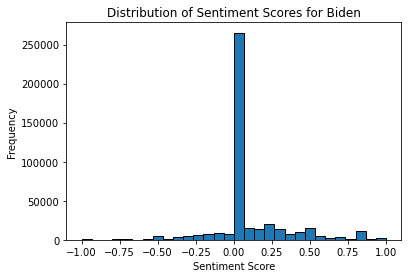

In [71]:
plt.hist(df_combined[df_combined['candidatepoll'] == 'Biden']['sentiment'], bins=30, edgecolor='black')

# Adding labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores for Biden')

# Show plot
plt.savefig('BidenSentDist.png')

## Data Source Proportions with Clean Data

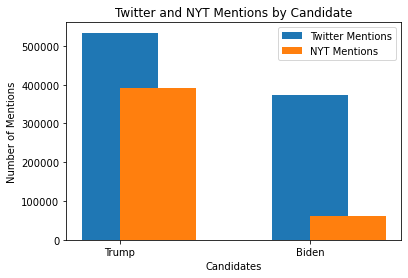

In [72]:
candidate = ['Trump','Biden']
twitter_n = [df_combined[df_combined['candidatepoll'] == 'Trump']['source'].value_counts()[0], 
             df_combined[df_combined['candidatepoll'] == 'Biden']['source'].value_counts()[0]]
nyt_n = [df_combined[df_combined['candidatepoll'] == 'Trump']['source'].value_counts()[1], 
         df_combined[df_combined['candidatepoll'] == 'Biden']['source'].value_counts()[1]]

x = range(len(candidate))

# Plotting the bars
plt.bar(x, twitter_n, width=0.4, label='Twitter Mentions', align='center')
plt.bar(x, nyt_n, width=0.4, label='NYT Mentions', align='edge')

# Adding labels
plt.xlabel('Candidates')
plt.ylabel('Number of Mentions')
plt.title('Twitter and NYT Mentions by Candidate')
plt.xticks(x, candidate)
plt.legend()

# Show plot
plt.savefig('DataDist.png')

# Additional Feature Engineering

## Create Outcome Variable

In [73]:
df_combined['SentimentOutcome'] = df_combined['candidatepoll']+"_"+df_combined['sentiment_category']

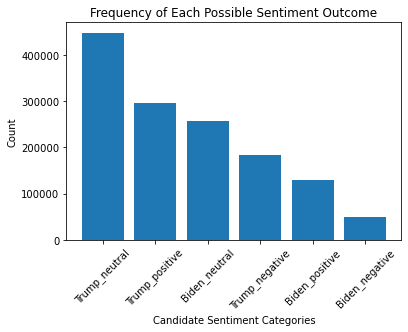

In [74]:
import matplotlib.pyplot as plt
category_counts = df_combined['SentimentOutcome'].value_counts()
plt.bar(category_counts.index, category_counts.values)
plt.xlabel('Candidate Sentiment Categories')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.ylabel('Count')
plt.title('Frequency of Each Possible Sentiment Outcome')
plt.show()

## Smallest category is Biden_negative. When using train/test/split with 90/5/5 ratio, we will need balancing.

In [75]:
 df_combined[df_combined['candidatepoll'] == 'Biden']['SentimentOutcome'].value_counts()

Biden_neutral     256228
Biden_positive    129638
Biden_negative     49060
Name: SentimentOutcome, dtype: int64

In [76]:
 df_combined[df_combined['candidatepoll'] == 'Trump']['SentimentOutcome'].value_counts()

Trump_neutral     448369
Trump_positive    295397
Trump_negative    182918
Name: SentimentOutcome, dtype: int64

In [220]:
df_combined.head(5)


,comment_body,source,user_location,candidatepoll,clean_text,clean_location,sentiment,sentiment_category,SentimentOutcome
0,We can all breathe now . #Biden,tweet,NY 🍎 LA | 🌎 Traveler | Not All Those Who Wan,Biden,We can all breathe now Biden,NY LA Traveler Not All Those Who Wan,0.00,neutral,Biden_neutral
1,#KamalaHarrisVP #JoeBiden JOE AND KAMALA DO ...,tweet,,Biden,KamalaHarrisVP JoeBiden JOE AND KAMALA DO NOT...,,0.33,positive,Biden_positive
2,Thank you @KingJames @CP3 &amp; the sporting w...,tweet,,Biden,Thank you KingJames CP3 amp the sporting world...,,0.00,neutral,Biden_neutral
3,"""@BBCNews #JoeBiden can we please savour this ...",tweet,158.0,Biden,BBCNews JoeBiden can we please savour this mo...,158 0,0.00,neutral,Biden_neutral
4,#Merkel #Allemagne #Biden https://t.co/fyq8r3siwN,tweet,"""Montréal",Biden,Merkel Allemagne Biden t co fyq8r3siwN,Montréal,0.00,neutral,Biden_neutral


# Save Data to S3 bucket

In [234]:
# Specify the S3 bucket name
prefix = "ADS508_project/cleandata/"

# List of corresponding file names
file_name = "cleandata.csv"

# Create an S3 client
s3 = boto3.client('s3')

#refine df_combined
df_combined_ref = df_combined[['source', 'clean_text', 'clean_location', 'candidatepoll', 'SentimentOutcome']]
df_combined_ref.head()

,source,clean_text,clean_location,candidatepoll,SentimentOutcome
0,tweet,We can all breathe now Biden,NY LA Traveler Not All Those Who Wan,Biden,Biden_neutral
1,tweet,KamalaHarrisVP JoeBiden JOE AND KAMALA DO NOT...,,Biden,Biden_positive
2,tweet,Thank you KingJames CP3 amp the sporting world...,,Biden,Biden_neutral
3,tweet,BBCNews JoeBiden can we please savour this mo...,158 0,Biden,Biden_neutral
4,tweet,Merkel Allemagne Biden t co fyq8r3siwN,Montréal,Biden,Biden_neutral


In [235]:
# Upload each file to S3
df_combined_ref.to_csv(file_name, index=False)
s3.upload_file(file_name, bucket, prefix + file_name)

In [236]:
# Create temp table of df_combined
temp_table = "temp_table"
s3_private_path_cleandata = "s3://{}/ADS508_project/cleandata".format(bucket)

statement = """
CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
    source VARCHAR(20),
    clean_text VARCHAR(250),
    clean_location VARCHAR(25),
    candidatepoll VARCHAR(10),
    SentimentOutcome VARCHAR(10)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')
""".format(
    database_name, temp_table, s3_private_path_cleandata
)

pd.read_sql(statement, conn)

""


In [237]:
# map df_combined/ cleandata with uscities by city
temp_table = "temp_table_city"
import time
from datetime import datetime
from time import strftime
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(f"start: {timestamp}\n")

statement = """
CREATE TABLE IF NOT EXISTS {}.{} AS (
SELECT DISTINCT 
    t.source, 
    t.clean_text, 
    t.clean_location, 
    t.candidatepoll, 
    t.SentimentOutcome, 
    u.state_id
    FROM  dbpoliticpulsecomment.temp_table t
    LEFT JOIN dbpoliticpulsecomment.uscities u
        ON lower(t.clean_location) = lower(u.city)
    where state_id <> ''
)
""".format(database_name, temp_table)
pd.read_sql(statement, conn)

timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(f"end: {timestamp}\n")

start: 2024-03-31T02:31:20Z

end: 2024-03-31T02:31:25Z



In [238]:
# map df_combined/ cleandata with uscities by statename
temp_table = "temp_table_statename"
import time
from datetime import datetime
from time import strftime
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(f"start: {timestamp}\n")

statement = """
CREATE TABLE IF NOT EXISTS {}.{} AS (
SELECT DISTINCT 
    t.source, 
    t.clean_text, 
    t.clean_location, 
    t.candidatepoll, 
    t.SentimentOutcome, 
    u.state_id
    FROM  dbpoliticpulsecomment.temp_table t
    LEFT JOIN dbpoliticpulsecomment.uscities u
        ON lower(t.clean_location) = lower(u.state_name)
    where state_id <> ''
)
""".format(database_name, temp_table)
pd.read_sql(statement, conn)

timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(f"end: {timestamp}\n")

start: 2024-03-31T02:31:25Z

end: 2024-03-31T02:31:41Z



In [239]:
# map df_combined/ cleandata with uscities by stateid
temp_table = "temp_table_stateid"
import time
from datetime import datetime
from time import strftime
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(f"start: {timestamp}\n")

statement = """
CREATE TABLE IF NOT EXISTS {}.{} AS (
SELECT DISTINCT 
    t.source, 
    t.clean_text, 
    t.clean_location, 
    t.candidatepoll, 
    t.SentimentOutcome, 
    u.state_id
    FROM  dbpoliticpulsecomment.temp_table t
    LEFT JOIN dbpoliticpulsecomment.uscities u
        ON lower(t.clean_location) = lower(u.state_id)
    where state_id <> ''
)
""".format(database_name, temp_table)
pd.read_sql(statement, conn)

timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(f"end: {timestamp}\n")

start: 2024-03-31T02:31:41Z

end: 2024-03-31T02:31:52Z



In [240]:
# Create a combine of temp_table_state_id, _statename, _city
table_name = "cleandata"
import time
from datetime import datetime
from time import strftime
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(f"start: {timestamp}\n")

statement = """
CREATE TABLE IF NOT EXISTS {}.{} AS (
SELECT DISTINCT 
    source, 
    clean_text, 
    clean_location, 
    candidatepoll, 
    SentimentOutcome, 
    state_id
    FROM  dbpoliticpulsecomment.temp_table_stateid
UNION
SELECT DISTINCT 
    source, 
    clean_text, 
    clean_location, 
    candidatepoll, 
    SentimentOutcome, 
    state_id
    FROM  dbpoliticpulsecomment.temp_table_city
UNION
SELECT DISTINCT 
    source, 
    clean_text, 
    clean_location, 
    candidatepoll, 
    SentimentOutcome, 
    state_id
    FROM  dbpoliticpulsecomment.temp_table_statename
)
""".format(database_name, table_name)
pd.read_sql(statement, conn)
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(f"end: {timestamp}\n")

start: 2024-03-31T02:31:52Z

end: 2024-03-31T02:31:53Z



In [241]:
# Drop all unused tables from Athena
drop_table_names = ["temp_table", "temp_table_statename", "temp_table_stateid", "temp_table_city"]

for table_name in drop_table_names:
    table_name = table_name

    statement = """
    DROP TABLE {}.{}
    """.format(database_name, table_name)
    
    pd.read_sql(statement, conn)

In [242]:
#==> SHOULD CREATE ANOTHER PARQUET OR READING FROM THIS? 
table_name = "cleandata"
statement = """SELECT * FROM {}.{}""".format(
    database_name, table_name
)
df_combined_clean = pd.read_sql(statement, conn)
df_combined_clean.head(5)

,source,clean_text,clean_location,candidatepoll,sentimentoutcome,state_id
0,tweet,From the guy who brought you Yub Nub I give yo...,LA,Biden,Biden_posi,LA
1,tweet,Congratulations to President Elect Joe Biden J...,NJ,Biden,Biden_posi,NJ
2,tweet,WE DID IT WE DID ITTTTTT HE WON IM SO HAPPY WE...,MI,Biden,Biden_posi,MI
3,tweet,Can I buy shares in Herbal Essence It must sme...,UK,Biden,Biden_posi,UK
4,nyt_comment,I believe that Biden is pragmatic and a funda...,NY,Biden,Biden_posi,NY


In [243]:
df_combined_clean.shape

(330266, 6)

# Examine State IDs by Outcome

In [244]:
df_final = df_combined_clean[['clean_text', 'state_id', 'sentimentoutcome']]

In [245]:
df_final['state_id'].value_counts()

NY    60211
CA    48063
TX    16138
FL    14830
NJ    13216
MA    13130
WA    13092
IL    12606
PA    12159
OH     8687
NC     7531
CO     7201
OR     6395
MI     6140
VA     6119
MD     5933
AZ     5780
CT     5757
GA     5621
MN     5001
WI     4910
UK     4012
MO     3592
WY     3095
NM     2942
LA     2546
NH     2450
IA     2366
ME     2340
NV     2297
SC     2246
IN     2143
VT     2015
TN     1999
RI     1811
ND     1809
AL     1460
KS     1415
OK     1304
KY     1194
ID     1066
UT      986
MT      963
AR      933
HI      911
AK      760
MS      730
NE      728
DE      538
SD      501
WV      294
PR      164
BC      136
Name: state_id, dtype: int64

In [246]:
# Step 1: Filter the DataFrame for the top 10 states
top_5_states = df_final['state_id'].value_counts().head(5).index
filtered_df = df_final[df_final['state_id'].isin(top_5_states)]

# Step 2: Create a cross-tabulation (crosstab) with 'state_id' and 'sentimentoutcome'
cross_tab = pd.crosstab(filtered_df['state_id'], filtered_df['sentimentoutcome'])

# Display the cross-tabulation
print(cross_tab)

sentimentoutcome  Biden_nega  Biden_neut  Biden_posi  Trump_nega  Trump_neut  \
state_id                                                                       
CA                      1217        2303        3312       11077       12563   
FL                       424         784        1183        3368        3611   
NJ                       343         545         845        3191        3347   
NY                      1811        3065        4834       13082       15524   
TX                       515        1447        1266        3157        4666   

sentimentoutcome  Trump_posi  
state_id                      
CA                     17591  
FL                      5460  
NJ                      4945  
NY                     21895  
TX                      5087  


In [247]:
df_final.head()

,clean_text,state_id,sentimentoutcome
0,From the guy who brought you Yub Nub I give yo...,LA,Biden_posi
1,Congratulations to President Elect Joe Biden J...,NJ,Biden_posi
2,WE DID IT WE DID ITTTTTT HE WON IM SO HAPPY WE...,MI,Biden_posi
3,Can I buy shares in Herbal Essence It must sme...,UK,Biden_posi
4,I believe that Biden is pragmatic and a funda...,NY,Biden_posi


# Upload Final Data to S3

In [248]:
# Specify the S3 bucket name
prefix = "ADS508_project/cleandata/"

# List of corresponding file names
file_name = "final_data.csv"

# Create an S3 client
s3 = boto3.client('s3')

df_final.to_csv(file_name, index=False)
s3.upload_file(file_name, bucket, prefix + file_name)

---> USING PYTHON AND TOOK FOREVER

In [93]:
# Read csv US City from S3 ---> PLANNING TO MOVE IT IN .py AND USE PREPROCESSING JOB FROM SAGEMAKER
#git_city_loc = "https://raw.githubusercontent.com/HNStaggs/ADS508_GroupProject/main/uscities.csv"
#df_city = pd.read_csv(git_city_loc)

#df_parquet_results_trump['clean_location'].head(15000)
#df_parquet_results_trump1 = df_parquet_results_trump.head(100)
#df_parquet_results_trump1.head(10)

In [94]:
# PREFER TO RUN IT IN .py with SageMaker processing job
# TRY IT WITH 10000 RECORD took FOREVER

#import time
#from datetime import datetime
#from time import strftime
#timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
#print(f"start: {timestamp}\n")

# Create master location table
#git_city_loc = "https://raw.githubusercontent.com/HNStaggs/ADS508_GroupProject/main/uscities.csv"
#df_city = pd.read_csv(git_city_loc)
#master_location = df_city

# Function to map city and state name to state ID
#def map_state_id(city):
#    for index, loc in master_location.iterrows():
#        if city.lower() == loc['city'].lower() or city.lower() == loc['state_name'].lower():
#            return loc['state_id']
#    return None

# Apply mapping function to user location table
#df_parquet_results_trump1['final_location'] = df_parquet_results_trump1['clean_location'].apply(map_state_id)  # Use clean location data from primary cleaning step

# Display the user location table with State ID column added
#timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")

#print(f"end: {timestamp}\n")


In [95]:
#df_parquet_results_trump1.shape

In [96]:
### working progress.. still need to check##
#from sagemaker.processing import ScriptProcessor

# Create a ScriptProcessor object
#script_processor = ScriptProcessor(base_job_name='data-processing',
#                                   image_uri=None,
#                                   command=['python3'],
#                                   instance_count=1,
#                                   instance_type='ml.m5.xlarge',
#                                   role=role)

# Specify the entry script
#entry_script = 's3://sagemaker-us-west-2-471112815505/ADS508_project/script/process_loc.py'

# Run the processing job
#script_processor.run(code=entry_script)


In [97]:
# Data Vis
# # creat colored maps by state based on sentiment

In [98]:
# Determime sample size from each state

In [99]:
# Determine portion of Trump/Biden for each state

# Load Final Data from S3 Bucket for Modeling

In [131]:
# Specify the S3 bucket name and file path
bucket_name = bucket
file_path = 'ADS508_project/cleandata/final_data.csv'

# Read CSV file from S3 bucket into DataFrame
df_final = pd.read_csv(f's3://{bucket_name}/{file_path}')

df_final.head()

,clean_text,state_id,sentimentoutcome
0,From the guy who brought you Yub Nub I give yo...,LA,Biden_posi
1,Congratulations to President Elect Joe Biden J...,NJ,Biden_posi
2,WE DID IT WE DID ITTTTTT HE WON IM SO HAPPY WE...,MI,Biden_posi
3,Can I buy shares in Herbal Essence It must sme...,UK,Biden_posi
4,I believe that Biden is pragmatic and a funda...,NY,Biden_posi


In [250]:
df_final.shape

(330266, 3)

In [132]:
df_final

,clean_text,state_id,sentimentoutcome
0,From the guy who brought you Yub Nub I give yo...,LA,Biden_posi
1,Congratulations to President Elect Joe Biden J...,NJ,Biden_posi
2,WE DID IT WE DID ITTTTTT HE WON IM SO HAPPY WE...,MI,Biden_posi
3,Can I buy shares in Herbal Essence It must sme...,UK,Biden_posi
4,I believe that Biden is pragmatic and a funda...,NY,Biden_posi
...,...,...,...
330261,Another step to the dictator title for god tr...,WY,Trump_posi
330262,Couldn t agree with Trump more Let s start by...,CA,Trump_posi
330263,Mark Miller Trump s most committed backers se...,NY,Trump_posi
330264,Trump is setting up the conditions for an ove...,TN,Trump_neut


In [252]:
df_final

,clean_text,state_id,sentimentoutcome
0,From the guy who brought you Yub Nub I give yo...,LA,Biden_posi
1,Congratulations to President Elect Joe Biden J...,NJ,Biden_posi
2,WE DID IT WE DID ITTTTTT HE WON IM SO HAPPY WE...,MI,Biden_posi
3,Can I buy shares in Herbal Essence It must sme...,UK,Biden_posi
4,I believe that Biden is pragmatic and a funda...,NY,Biden_posi
...,...,...,...
330261,Another step to the dictator title for god tr...,WY,Trump_posi
330262,Couldn t agree with Trump more Let s start by...,CA,Trump_posi
330263,Mark Miller Trump s most committed backers se...,NY,Trump_posi
330264,Trump is setting up the conditions for an ove...,TN,Trump_neut


In [253]:
df_final

,clean_text,state_id,sentimentoutcome
0,From the guy who brought you Yub Nub I give yo...,LA,Biden_posi
1,Congratulations to President Elect Joe Biden J...,NJ,Biden_posi
2,WE DID IT WE DID ITTTTTT HE WON IM SO HAPPY WE...,MI,Biden_posi
3,Can I buy shares in Herbal Essence It must sme...,UK,Biden_posi
4,I believe that Biden is pragmatic and a funda...,NY,Biden_posi
...,...,...,...
330261,Another step to the dictator title for god tr...,WY,Trump_posi
330262,Couldn t agree with Trump more Let s start by...,CA,Trump_posi
330263,Mark Miller Trump s most committed backers se...,NY,Trump_posi
330264,Trump is setting up the conditions for an ove...,TN,Trump_neut


## Autopilot 

In [167]:
# # Sample about 10% of the data without replacement ---just to test------
# df_sampled = df_final.sample(frac=0.1, random_state=42)
# # Save the sampled DataFrame to a CSV file, without the index
# df_sampled.to_csv("df_sampled.csv", index=False)

In [179]:
# Save the DataFrame to a CSV file, without the index
df_final.to_csv("df_final.csv", index=False)

In [181]:
import boto3
from botocore.exceptions import NoCredentialsError

s3 = boto3.client('s3')
bucket_name = '508group'  # Replace with your bucket name
file_name = "df_final.csv"  
key = 'ADS508_project/cleandata/df_final.csv'  

try:
    s3.upload_file(file_name, bucket_name, key)
    print(f"File uploaded successfully to s3://{bucket_name}/{key}")
except FileNotFoundError:
    print("The file was not found")
except NoCredentialsError:
    print("Credentials not available")

File uploaded successfully to s3://508group/ADS508_project/cleandata/df_final.csv


In [184]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.automl.automl import AutoML

role = get_execution_role()
session = sagemaker.Session()

# Replace 'your_dataset.csv' with the name of your CSV file
input_data = 's3://508group/ADS508_project/cleandata/df_final.csv'

autopilot_job = AutoML(
    role=role,
    target_attribute_name='sentimentoutcome',  # This is the column you're predicting
    output_path='s3://508group/ADS508_project/output/autopilot/',
    max_candidates=20,
    sagemaker_session=session,
    problem_type='MulticlassClassification',  # Assuming sentimentoutcome is multiclass
    job_objective={'MetricName': 'Accuracy'}  # You can choose another metric if it fits better
)

autopilot_job.fit(inputs=input_data, wait=False, logs=True)


INFO:sagemaker:Creating auto-ml-job with name: automl-2024-03-30-22-01-39-094


In [186]:
import boto3
import tarfile
import os

# Initialize the S3 client
s3 = boto3.client('s3')

# S3 bucket and object key
bucket_name = '508group'
object_key = 'ADS508_project/output/autopilot/automl-2024-03-30-19-51-00-981/data-processor-models/automl-2024-03-30-19-51-00-981-dpp9-1-89acfb1b856c4754873c58ddd/output/model.tar.gz'

# Local directory to extract the contents
extract_dir = "ADS508_project/output/autopilot/automl-2024-03-30-19-51-00-981/data-processor-models/automl-2024-03-30-19-51-00-981-dpp9-1-89acfb1b856c4754873c58ddd/output/model.tar.gz"

# Create the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Download the file from S3
local_file_path = os.path.join(extract_dir, 'model.tar.gz')
s3.download_file(bucket_name, object_key, local_file_path)

# Open the tar file and extract the contents
with tarfile.open(local_file_path, "r:gz") as tar:
    tar.extractall(path=extract_dir)

# After extraction, you can further process or use the contents of the extracted files
# For example, list the extracted files
extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)


Extracted files: ['model.joblib', 'model.tar.gz', 'code']


In [208]:
# pip install -U scikit-learn

In [197]:
# Download the file from S3
local_file_path = os.path.join(extract_dir, 'model.tar.gz')
s3.download_file(bucket_name, object_key, local_file_path)

# Extract the contents of the tar.gz file
with tarfile.open(local_file_path, "r:gz") as tar:
    tar.extractall(path=extract_dir)



In [231]:
# pip install --upgrade numpy scipy

# Data Partition

### Assign input and outcome variables

In [133]:
X = df_final[['clean_text', 'state_id']]
y = df_final['sentimentoutcome']

### Create a 90/5/5 data split

In [134]:
from sklearn.model_selection import train_test_split

# Split data into 90% train and 10% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Split remaining data (90% train) into 90% train and 10% validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state=1)

### Further undersample the training set so that each level of the outcome variable is equal

In [135]:
#!pip install imblearn
from imblearn.under_sampling import RandomUnderSampler

# Undersample the training set to balance the six categorical outcome levels
undersampler = RandomUnderSampler(sampling_strategy='all', random_state=1)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

## Verify split datasets size and datatypes

In [136]:
X_train_resampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44112 entries, 18270 to 305997
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   clean_text  44112 non-null  object
 1   state_id    44112 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


In [137]:
# Update Datatypes
X_train_resampled['clean_text'] = X_train_resampled['clean_text'].astype(str)
X_train_resampled['state_id'] = X_train_resampled['state_id'].astype('category')

In [107]:
X_train_resampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44112 entries, 18270 to 305997
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   clean_text  44112 non-null  object  
 1   state_id    44112 non-null  category
dtypes: category(1), object(1)
memory usage: 734.8+ KB


In [108]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33027 entries, 285170 to 259549
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   clean_text  33027 non-null  object
 1   state_id    33027 non-null  object
dtypes: object(2)
memory usage: 774.1+ KB


In [109]:
# Update Datatypes
X_test['clean_text'] = X_test['clean_text'].astype(str)
X_test['state_id'] = X_test['state_id'].astype('category')

In [110]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33027 entries, 100683 to 257149
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   clean_text  33027 non-null  object
 1   state_id    33027 non-null  object
dtypes: object(2)
memory usage: 774.1+ KB


In [111]:
# Update Datatypes
X_val['clean_text'] = X_val['clean_text'].astype(str)
X_val['state_id'] = X_val['state_id'].astype('category')

In [139]:
X_train_resampled.shape, X_test.shape, X_val.shape

((44112, 2), (33027, 2), (33027, 2))

In [138]:
X_train_resampled.head()

,clean_text,state_id
18270,Empty platitudes and disappointment will be th...,NY
202468,Yeah but Biden didn t mean it If he did,MI
23476,Dee if Trump is guilty as you say then Obama ...,CA
76412,jdbos The reason they didn t ask is because t...,FL
66908,Biden is confused You are comparing him to a ...,LA


In [140]:
X_test.head()

,clean_text,state_id
285170,Trump s mentally ill inner turmoil is on full...,PA
285061,It seems that the trump party is ALWAYS going...,FL
2515,profwilliams My judgement about Trump and his...,NY
156238,I d like to know what Trumpers think I mean i...,IA
35258,Anyone else notice how bad Trump looks lately...,NJ


In [115]:
X_val.head()

,clean_text,state_id
100683,trump s off the cuff comments have gone beyon...,NJ
322288,Let s wait to see how Georgia plays out befor...,TX
25674,By 2024 Trump should be having no time for ca...,NY
127096,COVID 19 doesn t change the reasons why peopl...,OH
222889,Too bad Trump failed to provide leadership wh...,NY


In [116]:
X_train

,clean_text,state_id
248554,Given the non response of the Trump administr...,NY
152252,D Price Already at it Trump Official Impeachm...,CA
229626,Both Obama and Trump got elected because the ...,NY
258456,Biden needs to restore competence as fast as ...,TX
318774,Wasn t planning on backing away from trump any...,GA
...,...,...
277187,Becoming a failed state I would say the US is...,MA
67026,President Elect Biden should apologize to the...,NY
264630,mltrueblood One thing is certain The facts th...,MI
122827,trblmkr and perhaps on trump s assertions tha...,ME


## Verify balance of training set

In [141]:
y_train_resampled.value_counts()

Biden_nega    7352
Biden_neut    7352
Biden_posi    7352
Trump_nega    7352
Trump_neut    7352
Trump_posi    7352
Name: sentimentoutcome, dtype: int64

## Average length of comments. 

In [142]:
# Function to count string word length
def count_word_length(text):
    words = text.split()
    return len(words)

# Add column to DataFrame
df_final['word_length'] = df_final['clean_text'].apply(lambda x: count_word_length(x))

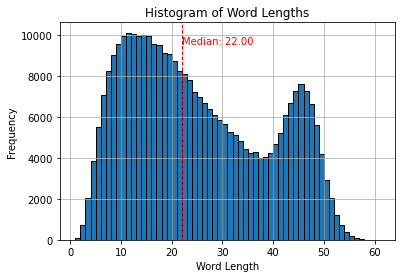

In [143]:
import numpy as np
median_word_length = np.median(df_final['word_length'])

# Plot histogram of word lengths
plt.hist(df_final['word_length'], bins=range(min(df_final['word_length']), max(df_final['word_length']) + 1), edgecolor='black')
plt.axvline(median_word_length, color='red', linestyle='dashed', linewidth=1)  # Add vertical line at median
plt.text(median_word_length, plt.ylim()[1] * 0.9, f'Median: {median_word_length:.2f}', color='red')  # Add label for median
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Histogram of Word Lengths')
plt.grid(True)
plt.show()

# Text Entry Preprocessing and Data Transformation Pipeline: Will Need to Add Categorical One-Hot Encoding if we use Location Data

In [120]:
!pip install gensim
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from gensim.models import Word2Vec

# Define custom transformer for Word2Vec embeddings
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window=5, min_count=1, workers=4):
        self.word2vec_model = Word2Vec(window=window, min_count=min_count, workers=workers)
    
    def fit(self, X, y=None):
        # Train Word2Vec model
        X_word_lists = [text.split()[:15] for text in X]  # Limit to first 15 words
        self.word2vec_model.build_vocab(X_word_lists)
        self.word2vec_model.train(X_word_lists, total_examples=len(X_word_lists), epochs=10)
        return self
    
    def transform(self, X):
        # Limit text to first 15 words and split into word lists
        X_word_lists = [text.split()[:15] for text in X]
        # Initialize a list to store word embeddings
        embeddings = []
        # Iterate over each word list
        for word_list in X_word_lists:
            # Initialize a list to store word embeddings for this word list
            word_embeddings = []
            # Iterate over each word in the word list
            for word in word_list:
                # Check if the word exists in the Word2Vec model's vocabulary
                if word in self.word2vec_model.wv:
                    # Retrieve the word embedding and append it to the list
                    word_embeddings.append(self.word2vec_model.wv[word])
                else:
                    # If the word doesn't exist in the vocabulary, append zeros
                    word_embeddings.append([0] * self.word2vec_model.vector_size)
            # Append the word embeddings for this word list to the embeddings list
            embeddings.append(word_embeddings)
        return embeddings

# Define preprocessing pipeline
text_pipeline = Pipeline([
    ('word2vec', Word2VecTransformer())
])

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [121]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline


cat = 'state_id'

# Define preprocessing pipeline
cat_pipeline = ColumnTransformer([
    ('onehot', OneHotEncoder(), [cat])  # Perform one-hot encoding for the 'state_id' column
])


In [122]:
# Fit and transform on the training set
X_train_transformed_text = pd.DataFrame(text_pipeline.fit_transform(X_train_resampled['clean_text']))

In [123]:
X_train_transformed_state = pd.DataFrame(cat_pipeline.fit_transform(X_train_resampled))
X_train_transformed_state.columns = ['state_id']

In [124]:
X_train_transformed_text.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,"[-0.034022156, 0.020868521, 0.0062629655, 0.00...","[-0.053827178, 0.055068173, 0.01354243, 0.0345...","[0.27330413, -0.6535227, 2.1337175, 0.96501327...","[-0.1639024, 0.2019843, -0.095293745, 0.111080...","[0.7073112, -1.2954994, -0.08386606, 0.9371881...","[-0.22636639, -2.0242612, 2.1055424, -0.078305...","[1.018408, -1.2881258, 1.361802, 1.1654738, -0...","[0.018628795, 0.037218295, 0.081868626, 0.0355...","[3.169192, -1.686239, 0.92418367, 1.7656312, 0...","[-1.4255806, 0.62008506, 1.645545, 1.0198312, ...","[-1.1567808, -1.730157, -1.1321992, 1.1523242,...","[-0.013867739, 0.22687778, 0.3939996, 0.268631...",None,None,None
1,"[-0.18327934, 0.16693516, 0.030861318, -0.0630...","[-0.6133865, -0.9356293, 0.70381194, -0.823132...","[-1.4255806, 0.62008506, 1.645545, 1.0198312, ...","[-1.760923, -0.16369714, -0.37284607, 0.185111...","[-2.208805, 1.5400424, -0.6933548, 0.5340035, ...","[-0.77638155, 0.06862942, -0.008541082, -1.346...","[-1.6742109, -0.3629744, -0.2866717, 0.3739421...","[-1.0872802, 0.52666557, 1.0767642, -2.5709233...","[-1.5294573, 0.6378274, 1.4669639, 0.19510289,...","[-0.036513865, -0.46350062, -0.6786844, 0.4507...",None,None,None,None,None


In [125]:
X_train_transformed_state.head()

,state_id
0,"(0, 34)\t1.0"
1,"(0, 22)\t1.0"
2,"(0, 5)\t1.0"
3,"(0, 9)\t1.0"
4,"(0, 18)\t1.0"


In [126]:
X_train = pd.concat([X_train_transformed_text, X_train_transformed_state], axis=1)

In [127]:
X_test_transformed_text = pd.DataFrame(text_pipeline.fit_transform(X_test['clean_text'])) 
X_test_transformed_state = pd.DataFrame(cat_pipeline.fit_transform(X_test))
X_test_transformed_state.columns = ['state_id']
X_test = pd.concat([X_test_transformed_text, X_test_transformed_state], axis=1)

In [128]:
X_val_transformed_text = pd.DataFrame(text_pipeline.fit_transform(X_val['clean_text'])) 
X_val_transformed_state = pd.DataFrame(cat_pipeline.fit_transform(X_val))
X_val_transformed_state.columns = ['state_id']
X_val = pd.concat([X_val_transformed_text, X_val_transformed_state], axis=1)

IndexError: index 27498 is out of bounds for axis 0 with size 27453

## Verify contents of DFs

In [144]:
X_train.head()

,clean_text,state_id
248554,Given the non response of the Trump administr...,NY
152252,D Price Already at it Trump Official Impeachm...,CA
229626,Both Obama and Trump got elected because the ...,NY
258456,Biden needs to restore competence as fast as ...,TX
318774,Wasn t planning on backing away from trump any...,GA


In [ ]:
X_val

In [ ]:
y_train_resampled.shape

In [ ]:
y_train_resampled.head()

In [ ]:
X_test.head()

In [ ]:
y_test.head()

In [ ]:
X_val.head()

In [ ]:
y_val.head()

## Modeling 

In [145]:
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [ ]:
# pip install transformers

### Trying a different Preprocess, since I was having trouble with Word2Vec (This step ignores anything after word2vec)

In [146]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm
import numpy as np

class DistilBERTTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Initialize the DistilBERT tokenizer and model
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.model.eval()  # Set model to evaluation mode
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, batch_size=32):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        embeddings = []
        for i in tqdm(range(0, len(X), batch_size)):
            batch = X[i:i+batch_size]
            inputs = self.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
            with torch.no_grad():
                outputs = self.model(**inputs)
            embeddings.append(outputs.last_hidden_state.mean(dim=1).detach().cpu().numpy())  # Use mean pooling
        return np.vstack(embeddings)

### BERT transformations

In [147]:
X_train

,clean_text,state_id
248554,Given the non response of the Trump administr...,NY
152252,D Price Already at it Trump Official Impeachm...,CA
229626,Both Obama and Trump got elected because the ...,NY
258456,Biden needs to restore competence as fast as ...,TX
318774,Wasn t planning on backing away from trump any...,GA
...,...,...
277187,Becoming a failed state I would say the US is...,MA
67026,President Elect Biden should apologize to the...,NY
264630,mltrueblood One thing is certain The facts th...,MI
122827,trblmkr and perhaps on trump s assertions tha...,ME


In [148]:
# Instantiate the transformer
distilbert_transformer = DistilBERTTransformer()

# Transform 'clean_text' into DistilBERT embeddings for the training set
texts_train = X_train['clean_text'].tolist()  # Extract texts as a list
distilbert_embeddings_train = distilbert_transformer.transform(texts_train)

# Repeat for validation and test sets as needed


100%|██████████| 8257/8257 [07:40<00:00, 17.92it/s]


In [149]:
# Transform 'clean_text' into DistilBERT embeddings for the validation set
texts_val = X_val['clean_text'].tolist()  # Extract texts as a list
distilbert_embeddings_val = distilbert_transformer.transform(texts_val)

100%|██████████| 1033/1033 [00:57<00:00, 18.05it/s]


In [150]:
# Transform 'clean_text' into DistilBERT embeddings for the test set
texts_test = X_test['clean_text'].tolist()  # Extract texts as a list
distilbert_embeddings_test = distilbert_transformer.transform(texts_test)


100%|██████████| 1033/1033 [00:57<00:00, 18.09it/s]


In [151]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False) 

# Assuming X_train, X_val, X_test are your datasets
state_ids_train = X_train['state_id'].values.reshape(-1, 1)  # Reshape for the encoder
state_id_encoded_train = onehot_encoder.fit_transform(state_ids_train)

/opt/conda/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [155]:
state_ids_val = X_val['state_id'].values.reshape(-1, 1)
state_id_encoded_val = onehot_encoder.transform(state_ids_val)

state_ids_test = X_test['state_id'].values.reshape(-1, 1)
state_id_encoded_test = onehot_encoder.transform(state_ids_test)

In [156]:
#Combine with sate ID that is one hot encoded
X_train_prepared = np.hstack((distilbert_embeddings_train, state_id_encoded_train))
X_val_prepared = np.hstack((distilbert_embeddings_val, state_id_encoded_val))
X_test_prepared = np.hstack((distilbert_embeddings_test, state_id_encoded_test))



## Logistic Regression as a baseline

In [286]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')

# Fit the model on the training data
log_reg.fit(X_train_prepared, y_train)

# Predict on the validation set
y_val_pred = log_reg.predict(X_val_prepared)

# Evaluate the model
print("Validation Set Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Set Classification Report:\n", classification_report(y_val, y_val_pred))


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Set Accuracy: 0.6441396433221304

Validation Set Classification Report:
               precision    recall  f1-score   support

  Biden_nega       0.49      0.29      0.36       900
  Biden_neut       0.71      0.75      0.73      1726
  Biden_posi       0.68      0.75      0.71      2469
  Trump_nega       0.55      0.40      0.47      7355
  Trump_neut       0.69      0.71      0.70      8681
  Trump_posi       0.64      0.73      0.68     11896

    accuracy                           0.64     33027
   macro avg       0.63      0.61      0.61     33027
weighted avg       0.64      0.64      0.64     33027



## MLP Model 1

In [158]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Use a pipeline to standardize features
mlp_pipeline = make_pipeline(
    StandardScaler(),
    MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, activation='relu', solver='adam', verbose=True, tol=0.001, alpha=0.0001)
)

# Fit the model
mlp_pipeline.fit(X_train_prepared, y_train)

# Predict and evaluate
y_val_pred = mlp_pipeline.predict(X_val_prepared)
print("Validation Set Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Set Classification Report:\n", classification_report(y_val, y_val_pred))


Iteration 1, loss = 0.86432177
Iteration 2, loss = 0.78825137
Iteration 3, loss = 0.76293808
Iteration 4, loss = 0.74180840
Iteration 5, loss = 0.72516686
Iteration 6, loss = 0.70897513
Iteration 7, loss = 0.69569723
Iteration 8, loss = 0.68349195
Iteration 9, loss = 0.67214032
Iteration 10, loss = 0.66064983
Iteration 11, loss = 0.65104152
Iteration 12, loss = 0.64207598
Iteration 13, loss = 0.63197257
Iteration 14, loss = 0.62437983
Iteration 15, loss = 0.61580190
Iteration 16, loss = 0.60967626
Iteration 17, loss = 0.60088120
Iteration 18, loss = 0.59404550
Iteration 19, loss = 0.58828909
Iteration 20, loss = 0.58216277
Iteration 21, loss = 0.57586322
Iteration 22, loss = 0.56946403
Iteration 23, loss = 0.56459254
Iteration 24, loss = 0.55893742
Iteration 25, loss = 0.55399814
Iteration 26, loss = 0.54821797
Iteration 27, loss = 0.54503045
Iteration 28, loss = 0.54015958
Iteration 29, loss = 0.53545384
Iteration 30, loss = 0.53104275
Iteration 31, loss = 0.52621620
Iteration 32, los

## MLP Model

In [289]:
from sklearn.neural_network import MLPClassifier

# Initialize the MLP Classifier

mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, activation='relu', solver='adam', verbose=True, tol=0.01)


# Fit the model on the training data
mlp.fit(X_train_prepared, y_train)

# Predict on the validation set
y_val_pred_mlp = mlp.predict(X_val_prepared)

# Evaluate the model
print("Validation Set Accuracy (MLP):", accuracy_score(y_val, y_val_pred_mlp))
print("\nValidation Set Classification Report (MLP):\n", classification_report(y_val, y_val_pred_mlp))


Iteration 1, loss = 0.88088519
Iteration 2, loss = 0.81637793
Iteration 3, loss = 0.79896415
Iteration 4, loss = 0.78563963
Iteration 5, loss = 0.77307836
Iteration 6, loss = 0.76299937
Iteration 7, loss = 0.75408237
Iteration 8, loss = 0.74642038
Iteration 9, loss = 0.73831446
Iteration 10, loss = 0.73065500
Iteration 11, loss = 0.72462643
Iteration 12, loss = 0.71891434
Iteration 13, loss = 0.71105125
Iteration 14, loss = 0.70638132
Iteration 15, loss = 0.70026020
Iteration 16, loss = 0.69491220
Iteration 17, loss = 0.68986309
Training loss did not improve more than tol=0.010000 for 10 consecutive epochs. Stopping.
Validation Set Accuracy (MLP): 0.6488630514427589

Validation Set Classification Report (MLP):
               precision    recall  f1-score   support

  Biden_nega       0.51      0.29      0.37       900
  Biden_neut       0.78      0.66      0.71      1726
  Biden_posi       0.65      0.84      0.74      2469
  Trump_nega       0.60      0.38      0.46      7355
  Trump_

## Transformer 

In [300]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Define device upfront
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming X_train_prepared, X_val_prepared, X_test_prepared and their respective y's are already defined

# Encode labels numerically
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "features": torch.tensor(self.features[idx], dtype=torch.float),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Dataset and DataLoader
train_dataset = CustomDataset(X_train_prepared, y_train_encoded)
val_dataset = CustomDataset(X_val_prepared, y_val_encoded)
test_dataset = CustomDataset(X_test_prepared, y_test_encoded)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Model Definition
class Classifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Classifier(input_size=X_train_prepared.shape[1], num_classes=len(set(y_train_encoded)))
model.to(device)

# Training
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 3
for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        features, labels = batch['features'].to(device), batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    

# Evaluation
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for batch in test_loader:
        features, labels = batch['features'].to(device), batch['labels'].to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("Test Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))



Test Accuracy: 0.6482272080419051
Classification Report:
              precision    recall  f1-score   support

  Biden_nega       0.51      0.22      0.30       866
  Biden_neut       0.75      0.75      0.75      1768
  Biden_posi       0.66      0.81      0.73      2455
  Trump_nega       0.56      0.41      0.47      7168
  Trump_neut       0.69      0.70      0.69      8700
  Trump_posi       0.65      0.73      0.69     12070

    accuracy                           0.65     33027
   macro avg       0.63      0.60      0.61     33027
weighted avg       0.64      0.65      0.64     33027



In [150]:
# import boto3
# import pandas as pd
# from io import StringIO

# # Create an S3 client
# s3 = boto3.client('s3')

# # Specify the name of the bucket
# bucket_name = '508group'

# # Ensure your DataFrame variables are defined here (X_train, y_train_resampled, X_test, y_test, X_val, y_val)

# # Define the DataFrames
# data_frames = {
#     'X_train': X_train,
#     'y_train_resampled': y_train_resampled,
#     'X_test': X_test,
#     'y_test': y_test,
#     'X_val': X_val,
#     'y_val': y_val,
# }

# # Upload each DataFrame as CSV to the "508group" bucket
# for key, df in data_frames.items():
#     try:
#         # Convert DataFrame to CSV string
#         csv_buffer = StringIO()
#         df.to_csv(csv_buffer, index=False)
        
#         # Upload CSV string to S3
#         s3.put_object(Body=csv_buffer.getvalue(), Bucket=bucket_name, Key=f'ADS508_project/cleandata/{key}.csv')
#         print(f"Successfully uploaded {key}")
#     except Exception as e:
#         print(f"Error uploading {key} to S3: {e}")

# # Define the S3 paths for the data now that they are uploaded
# s3_paths = {
#     'X_train': 's3://508group/ADS508_project/cleandata/X_train.csv',
#     'y_train_resampled': 's3://508group/ADS508_project/cleandata/y_train_resampled.csv',
#     'X_test': 's3://508group/ADS508_project/cleandata/X_test.csv',
#     'y_test':  's3://508group/ADS508_project/cleandata/y_test.csv',
#     'X_val': 's3://508group/ADS508_project/cleandata/X_val.csv',
#     'y_val': 's3://508group/ADS508_project/cleandata/y_val.csv',
# }
# output_path = 's3://508group/ADS508_project/output/'

# You can now use `s3_paths` dictionary to access your data in S3 for any further processing


Successfully uploaded X_train
Successfully uploaded y_train_resampled
Successfully uploaded X_test
Successfully uploaded y_test
Successfully uploaded X_val
Successfully uploaded y_val


In [148]:
# !pip install -U sagemaker

In [147]:
# pip install XGBoost

In [ ]:
# import boto3
# import pandas as pd
# from io import StringIO

# # Create an S3 client
# s3 = boto3.client('s3')

# # Specify the name of the bucket
# bucket_name = '508group'

# # Define the DataFrames
# data_frames = {
#     'X_train': X_train,
#     'y_train_resampled': y_train_resampled,
#     'X_test': X_test,
#     'y_test': y_test,
#     'X_val': X_val,
#     'y_val': y_val,
# }

# # Upload each DataFrame as CSV to the "508group" bucket
# for key, df in data_frames.items():
#     try:
#         # Convert DataFrame to CSV string
#         csv_buffer = StringIO()
#         df.to_csv(csv_buffer, index=False)
        
#         # Upload CSV string to S3
#         s3.put_object(Body=csv_buffer.getvalue(), Bucket=bucket_name, Key=f'ADS508_project/cleandata/{key}.csv')
#     except Exception as e:
#         print(f"Error uploading {key} to S3: {e}")


In [ ]:
# # Define the S3 paths for training data, model output, etc.
# X_train = 's3://508group/ADS508_project/cleandata/X_train.csv'
# y_train_resampled = 's3://508group/ADS508_project/cleandata/y_train_resampled.csv'
# X_test = 's3://508group/ADS508_project/cleandata/X_test.csv'
# y_test =  's3://508group/ADS508_project/cleandata/y_test.csv'
# X_val = 's3://508group/ADS508_project/cleandata/X_val.csv'
# y_val = 's3://508group/ADS508_project/cleandata/y_val.csv'
# output_path = 's3://508group/ADS508_project/output/'


In [170]:
# import sagemaker
# from sagemaker import get_execution_role
# from sagemaker.inputs import TrainingInput
# from sagemaker.estimator import Estimator

# # Step 1: Define S3 paths for training data, model output, etc.
# s3_input_train = 's3://508group/ADS508_project/cleandata/X_train.csv'
# s3_input_test = 's3://508group/ADS508_project/cleandata/X_test.csv'
# output_path = 's3://508group/ADS508_project/output/'

# # Step 2: Create a SageMaker session and specify the IAM role
# sagemaker_session = sagemaker.Session()
# role = get_execution_role()

# # Step 3: Define the SageMaker XGBoost estimator with the specific version and hyperparameters
# xgb_estimator = Estimator(image_uri=sagemaker.image_uris.retrieve("xgboost", sagemaker_session.boto_region_name, "1.7-1"),
#                           role=role,
#                           instance_count=1,
#                           instance_type='ml.m5.large',
#                           output_path=output_path,
#                           sagemaker_session=sagemaker_session,
#                           hyperparameters={'num_round': '10'})  # Specify the number of boosting rounds

# # Step 4: Train the XGBoost model
# xgb_estimator.fit({'train': s3_input_train, 'validation': s3_input_test})

In [175]:
# import boto3
# import os

# # Initialize a boto3 client
# s3 = boto3.client('s3')

# # Function to download a file from an S3 bucket
# def download_file(bucket_name, object_key, local_filename):
#     try:
#         s3.download_file(Bucket=bucket_name, Key=object_key, Filename=local_filename)
#         print(f"Downloaded {object_key} to {local_filename}")
#     except Exception as e:
#         print(f"Error downloading {object_key}: {e}")

# # Define your bucket name
# bucket_name = '508group'

# # List of artifacts to download
# artifacts = {
#     "feature_engineering_code": "ADS508_project/output/autopilot/automl-2024-03-30-19-48-01-733/sagemaker-automl-candidates/automl-2024-03-30-19-48-01-733-pr-1-5cdcc23566e2483f97658942125/generated_module/candidate_data_processors/dpp9.py",
#     # Add other artifacts here following the same structure
# }

# # Download each artifact
# for name, key in artifacts.items():
#     download_file(bucket_name, key, f"{name}.py")


Downloaded ADS508_project/output/autopilot/automl-2024-03-30-19-48-01-733/sagemaker-automl-candidates/automl-2024-03-30-19-48-01-733-pr-1-5cdcc23566e2483f97658942125/generated_module/candidate_data_processors/dpp9.py to feature_engineering_code.py


In [177]:
# import boto3
# import os

# # Define key for the feature engineering code
# fe_code_key = 'ADS508_project/output/autopilot/automl-2024-03-30-19-48-01-733/sagemaker-automl-candidates/automl-2024-03-30-19-48-01-733-pr-1-5cdcc23566e2483f97658942125/generated_module/candidate_data_processors/dpp3.py'
# download_from_s3(bucket_name, fe_code_key, 'dpp3.py')

Downloaded ADS508_project/output/autopilot/automl-2024-03-30-19-48-01-733/sagemaker-automl-candidates/automl-2024-03-30-19-48-01-733-pr-1-5cdcc23566e2483f97658942125/generated_module/candidate_data_processors/dpp3.py to dpp3.py


In [ ]:
# import boto3
# import os

# s3 = boto3.client('s3')

# def download_from_s3(bucket_name, s3_key, local_path):
#     try:
#         s3.download_file(bucket_name, s3_key, local_path)
#         print(f"Downloaded {s3_key} to {local_path}")
#     except Exception as e:
#         print(f"Error downloading {s3_key}: {e}")

# bucket_name = '508group' 

In [ ]:
# import boto3
# import pandas as pd
# from io import StringIO

# # Create an S3 client
# s3 = boto3.client('s3')

# # Specify the name of the bucket
# bucket_name = '508group'

# # Define the DataFrames
# data_frames = {
#     'X_train': X_train,
#     'y_train_resampled': y_train_resampled,
#     'X_test': X_test,
#     'y_test': y_test,
#     'X_val': X_val,
#     'y_val': y_val,
# }

# # Upload each DataFrame as CSV to the "508group" bucket
# for key, df in data_frames.items():
#     try:
#         # Convert DataFrame to CSV string
#         csv_buffer = StringIO()
#         df.to_csv(csv_buffer, index=False)
        
#         # Upload CSV string to S3
#         s3.put_object(Body=csv_buffer.getvalue(), Bucket=bucket_name, Key=f'ADS508_project/cleandata/{key}.csv')
#     except Exception as e:
#         print(f"Error uploading {key} to S3: {e}")



In [ ]:
# import sagemaker
# from sagemaker.tensorflow import TensorFlow

# # Define your SageMaker session
# sagemaker_session = sagemaker.Session()

In [ ]:
# # Define the S3 paths for training data, model output, etc.
# X_train = 's3://508group/ADS508_project/cleandata/X_train.csv'
# y_train_resampled = 's3://508group/ADS508_project/cleandata/y_train_resampled.csv'
# X_test = 's3://508group/ADS508_project/cleandata/X_test.csv'
# y_test =  's3://508group/ADS508_project/cleandata/y_test.csv'
# X_val = 's3://508group/ADS508_project/cleandata/X_val.csv'
# y_val = 's3://508group/ADS508_project/cleandata/y_val.csv'
# output_path = 's3://508group/ADS508_project/output/'


In [ ]:

# # Load y_train_resampled.csv
# y_train_resampled_df = pd.read_csv('s3://508group/ADS508_project/cleandata/y_train_resampled.csv')

# # Prefix labels with '__label__'
# y_train_resampled_df['sentimentoutcome'] = '__label__' + y_train_resampled_df['sentimentoutcome'].astype(str)

# # Save the modified DataFrame back to y_train_resampled.csv
# y_train_resampled_df.to_csv('s3://508group/ADS508_project/cleandata/y_train_resampled.csv', index=False)


# # Load y_val.csv
# y_val_df = pd.read_csv('s3://508group/ADS508_project/cleandata/y_val.csv')

# # Prefix labels with '__label__'
# y_val_df['sentimentoutcome'] = '__label__' + y_val_df['sentimentoutcome'].astype(str)

# # Save the modified DataFrame back to y_val.csv
# y_val_df.to_csv('s3://508group/ADS508_project/cleandata/y_val.csv', index=False)

In [ ]:

# import boto3
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from joblib import dump
# import os

# # Load data from S3
# s3 = boto3.client('s3')
# bucket_name = '508group'

# def load_data_from_s3(key):
#     response = s3.get_object(Bucket=bucket_name, Key=key)
#     data = pd.read_csv(response['Body'])
#     return data

# # Load training data
# X_train = load_data_from_s3('ADS508_project/cleandata/X_train.csv')
# y_train = load_data_from_s3('ADS508_project/cleandata/y_train_resampled.csv')

# # Train logistic regression model
# model = LogisticRegression()
# model.fit(X_train_final, y_train_final)

# # Evaluate model
# y_pred = model.predict(X_val)
# accuracy = accuracy_score(y_val, y_pred)
# classification_rep = classification_report(y_val, y_pred)

# # Save the trained model
# output_dir = 'model'
# os.makedirs(output_dir, exist_ok=True)
# model_path = os.path.join(output_dir, 'model.joblib')
# dump(model, model_path)

# # Save evaluation metrics
# metrics_path = os.path.join(output_dir, 'metrics.txt')
# with open(metrics_path, 'w') as f:
#     f.write(f'Accuracy: {accuracy}\n')
#     f.write('Classification Report:\n')
#     f.write(classification_rep)

# # Upload the trained model and metrics to S3
# s3.upload_file(model_path, bucket_name, 'ADS508_project/output/model.joblib')
# s3.upload_file(metrics_path, bucket_name, 'ADS508_project/output/metrics.txt')


## Run Data Bias Analysis

In [ ]:
# Create folder for specific timestamp
import time

timestamp = int(time.time())

bias_data_s3_uri = sess.upload_data(bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path)
bias_data_s3_uri

In [ ]:
!aws s3 ls $bias_data_s3_uri

In [ ]:
balanced_bias_data_s3_uri = sess.upload_data(
    bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path_balance
)
balanced_bias_data_s3_uri

In [ ]:
!aws s3 ls $balanced_bias_data_s3_uri

In [ ]:
balanced_bias_data_jsonlines_s3_uri = sess.upload_data(
    bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path_jsonlines
)
balanced_bias_data_jsonlines_s3_uri

In [ ]:
!aws s3 ls $balanced_bias_data_jsonlines_s3_uri

In [ ]:
#!pip install --force-reinstall -q smclarify

from smclarify.bias import report
from typing import Dict
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!aws s3 cp $bias_data_s3_uri ./data-clarify/

In [ ]:
!aws s3 cp $balanced_bias_data_s3_uri ./data-clarify/

### Calculate Bias Metrics for all Data
#### might not needed from ===>

facet_column = report.FacetColumn(name="candidatepoll")

label_column = report.LabelColumn(
    name="sentiment_category", 
    series=df_combined["sentiment_category"],
    positive_label_values=[5]
)

In [ ]:
report.bias_report(
    df=df_combined, 
    facet_column=facet_column, 
    label_column=label_column, 
    stage_type=report.StageType.PRE_TRAINING, 
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

### Calculate Bias Metrics for Balanced Data

In [ ]:
from smclarify.bias import report

facet_column = report.FacetColumn(name="candidatepoll")

label_column = report.LabelColumn(
    name="sentiment_category", 
    series=df_balanced["sentiment_category"], 
    positive_label_values=[5]
)

In [ ]:
report.bias_report(
    df=df_balanced, 
    facet_column=facet_column, 
    label_column=label_column, 
    stage_type=report.StageType.PRE_TRAINING, 
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

#### <=== TO MIGHT NOT NEEDED

### Run Data Bias Analysis (Pre-training)

In [ ]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, 
    instance_count=1, 
    instance_type="ml.c5.xlarge", 
    sagemaker_session=sess
)

#### Pre-Training Bias

In [ ]:
bias_report_output_path = "s3://{}/ADS508_project/clarify".format(bucket)

bias_data_config = clarify.DataConfig(
    s3_data_input_path=bias_data_s3_uri,
    s3_output_path=bias_report_output_path,
    label="sentiment_category",
    headers=df_combined.columns.to_list(),
    dataset_type="text/csv",
)


In [ ]:
# Trump
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[5],
    facet_name="candidatepoll",
    facet_values_or_threshold=["Trump"],
)

clarify_processor.run_pre_training_bias(
    data_config=bias_data_config, 
    data_bias_config=bias_config, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False, 
    logs=False
)

run_pre_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_pre_training_bias_processing_job_name



In [ ]:
# Biden
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[5],
    facet_name="candidatepoll",
    facet_values_or_threshold=["Biden"],
)

clarify_processor.run_pre_training_bias(
    data_config=bias_data_config, 
    data_bias_config=bias_config, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False, 
    logs=False
)

run_pre_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_pre_training_bias_processing_job_name


#### Download report

In [ ]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)

from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(
            bucket, run_pre_training_bias_processing_job_name, region
        )
    )
)

In [ ]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=run_pre_training_bias_processing_job_name, sagemaker_session=sess
)

processing_job_description = running_processor.describe()

print(processing_job_description)

In [ ]:
!aws s3 ls $bias_report_output_path/

In [ ]:
!aws s3 cp --recursive $bias_report_output_path ./generated_bias_report/

In [ ]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./generated_bias_report/report.html">Bias Report</a></b>'))

In [ ]:
path = "./data-clarify/amazon_reviews_us_giftcards_software_videogames.csv"
df.to_csv(path, index=False, header=True)

In [ ]:
_testing